<a href="https://colab.research.google.com/github/DRepresser/NeuroClassify/blob/main/plot_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q fair-esm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import esm
import gc

from sklearn.decomposition import PCA

from tqdm import tqdm

In [20]:
df = pd.read_csv("/content/drive/MyDrive/ESM/data_clean/clustered_positive.csv")
df

,sequence,label,cluster_id
0,IGLRLPNMLKF,1,6524
1,LRSPKMMHKSGCFGRRLDRIGSLSGLGCNVLRKY,1,5748
2,GLYSSERTEEEVEISHGMHHRE,1,311529
3,SPTISITAPIDVLRKTWAKENMRKQMQINREYLKNLQ,1,127174
4,SQEPPISLDLTFHLLREVLEMTKADQLAQQAHNNRKLLDIA,1,8026
...,...,...,...
2582012,VNICKLYRGLPII,1,171927
2582013,DKEKEEKVNICKLYRGLPII,1,171927
2582014,GYKDKEKEEKVNICKLYRGLPII,1,171927
2582015,SWYRAPPRGRRYRAYSTTT,1,315145


In [21]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
batch_converter = alphabet.get_batch_converter()

In [39]:
def extract_esm_features(df, batch_size=2048):
    """
    Extract ESM embeddings for a dataset using bf16 precision (optimized version).

    Parameters:
    - df: DataFrame with a column for sequences.
    - batch_size: Number of sequences to process per batch.

    Returns:
    - A NumPy array containing embeddings for each sequence.
    """

    torch.set_float32_matmul_precision('high')
    all_embeddings = [None] * len(df)

    for i in tqdm(range(0, len(df), batch_size), desc="Extracting ESM Features"):
        batch_sequences = df.iloc[i:i + batch_size]
        data = [(str(index), row['sequence']) for index, row in batch_sequences.iterrows()]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        batch_tokens = batch_tokens.to(device)

        try:
            with torch.no_grad():
                with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
                    results = model(batch_tokens, repr_layers=[33])
                    token_embeddings = results["representations"][33]

            for j, (_, seq) in enumerate(data):
                embedding = token_embeddings[j, 1:len(seq) + 1].mean(0).cpu().numpy()
                all_embeddings[i + j] = embedding

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                torch.cuda.empty_cache()
                gc.collect()
                continue
            else:
                raise e

        del batch_tokens, results, token_embeddings
        torch.cuda.empty_cache()
        gc.collect()

    return np.array(all_embeddings)

In [40]:
df_features = extract_esm_features(df)

Extracting ESM Features: 100%|██████████| 1261/1261 [49:35<00:00,  2.36s/it]


In [41]:
df_features.shape

(2582017, 1280)

In [49]:
df_features

array([[ 0.02624998,  0.00076456,  0.13567872, ...,  0.01360696,
        -0.06620452, -0.08657238],
       [-0.02032648, -0.02951543,  0.01474623, ..., -0.23108512,
        -0.00539436, -0.04516983],
       [ 0.05668601,  0.05302939,  0.04597989, ...,  0.04092379,
        -0.04686224,  0.02464263],
       ...,
       [ 0.04922976,  0.03209996, -0.01963775, ...,  0.08032808,
        -0.01627936, -0.00024365],
       [ 0.06371722,  0.06235442,  0.08405387, ...,  0.04055541,
         0.03513911, -0.02481192],
       [ 0.02064825,  0.10495555,  0.11326572, ...,  0.01689245,
        -0.04040864,  0.02757357]], dtype=float32)

In [42]:
pca = PCA(n_components=2)
train_reduced_features = pca.fit_transform(df_features)

In [43]:
train_reduced_features.shape

(2582017, 2)

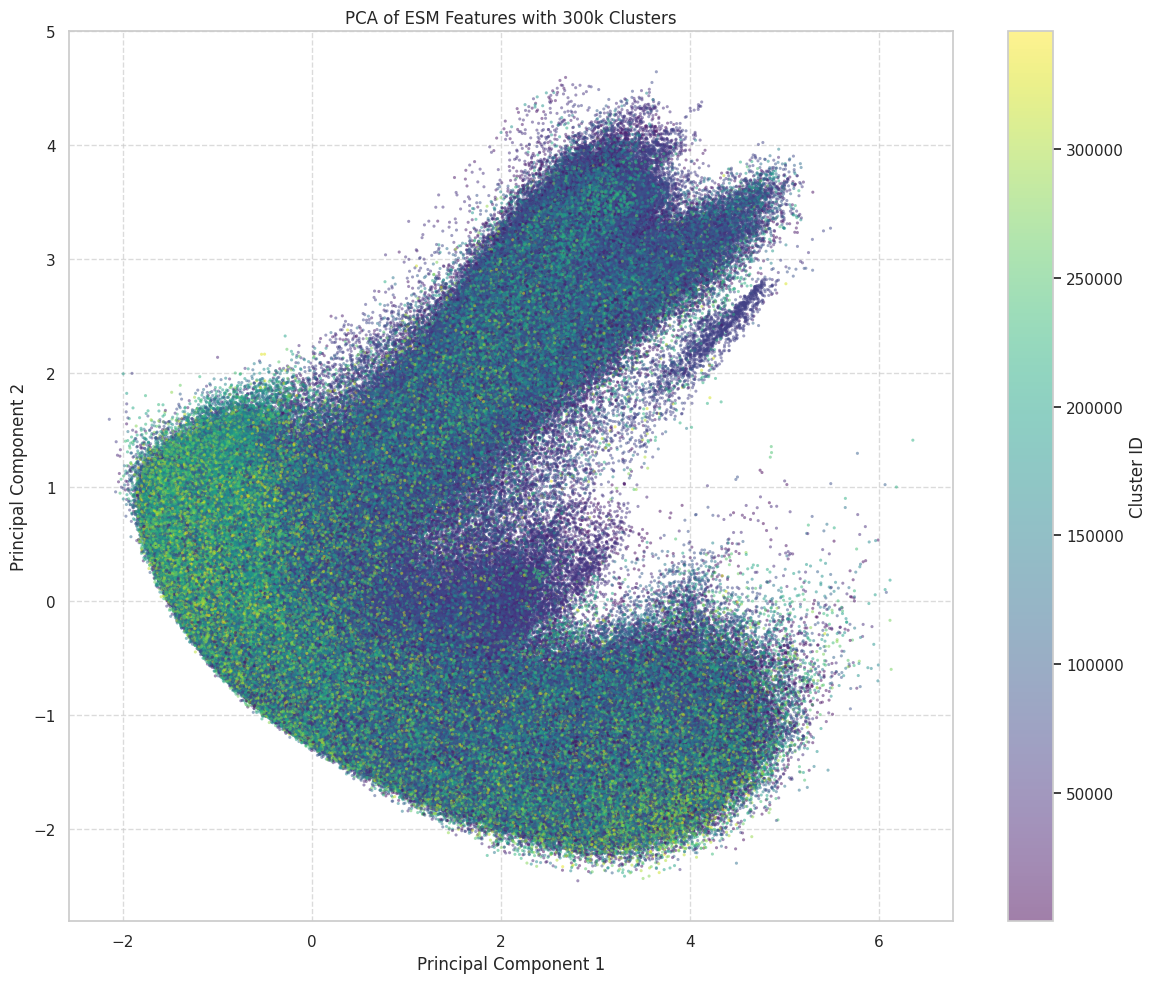

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

scatter = plt.scatter(
    train_reduced_features[:, 0],
    train_reduced_features[:, 1],
    c=df['cluster_id'],
    cmap='viridis',
    s=5,
    alpha=0.5,
    edgecolor='none'
)

plt.title("PCA of ESM Features with 300k Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID')

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [50]:
df['embedding'] = list(df_features)
sampled_df = df.groupby('cluster_id').apply(lambda x: x.sample(1)).reset_index(drop=True)
sampled_sequences = sampled_df[['sequence', 'cluster_id']]
sampled_embeddings = np.array([embedding for embedding in sampled_df['embedding']])

<ipython-input-50-baf4729b23e8>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('cluster_id').apply(lambda x: x.sample(1)).reset_index(drop=True)


                                             sequence  cluster_id
0                                       IFTMDFSKAFDCV           9
1                                        SLCAVMVFAVVE          14
2                                        GLAGRGRGRGRG          15
3                         NPFVLSANLHGGSLVANYPFDDYDPNG          21
4       MPRGSALLLAALLLAAALSATPGLGSPAKEKRGWTLNSAGYLLGP          30
...                                               ...         ...
337373                                    GWVCXAETSQW      345779
337374                                    HVMTIRHVMTI      345780
337375                                    AAAPDIAPSLT      345781
337376                                    MCFFISRGSEP      345782
337377                                    GRKTSGPGWDY      345783

[337378 rows x 2 columns]


In [52]:
sampled_df

,sequence,label,cluster_id,embedding
0,IFTMDFSKAFDCV,1,9,"[0.018706674, 0.09927636, -0.0060717235, 0.119..."
1,SLCAVMVFAVVE,1,14,"[0.019300885, 0.031630725, 0.16260599, 0.09713..."
2,GLAGRGRGRGRG,1,15,"[0.013196054, 0.07520603, 0.09852187, -0.16451..."
3,NPFVLSANLHGGSLVANYPFDDYDPNG,1,21,"[0.09116975, -0.19129078, 0.03133327, 0.019599..."
4,MPRGSALLLAALLLAAALSATPGLGSPAKEKRGWTLNSAGYLLGP,1,30,"[0.034548096, 0.061482687, 0.08993909, 0.05130..."
...,...,...,...,...
337373,GWVCXAETSQW,1,345779,"[0.055241834, 0.07870657, 0.13055749, 0.083248..."
337374,HVMTIRHVMTI,1,345780,"[0.072609976, 0.079607435, 0.13342904, -0.0276..."
337375,AAAPDIAPSLT,1,345781,"[-0.0665013, 0.13344888, 0.012643485, 0.232551..."
337376,MCFFISRGSEP,1,345782,"[0.09940346, 0.11011297, 0.23310375, 0.1484732..."


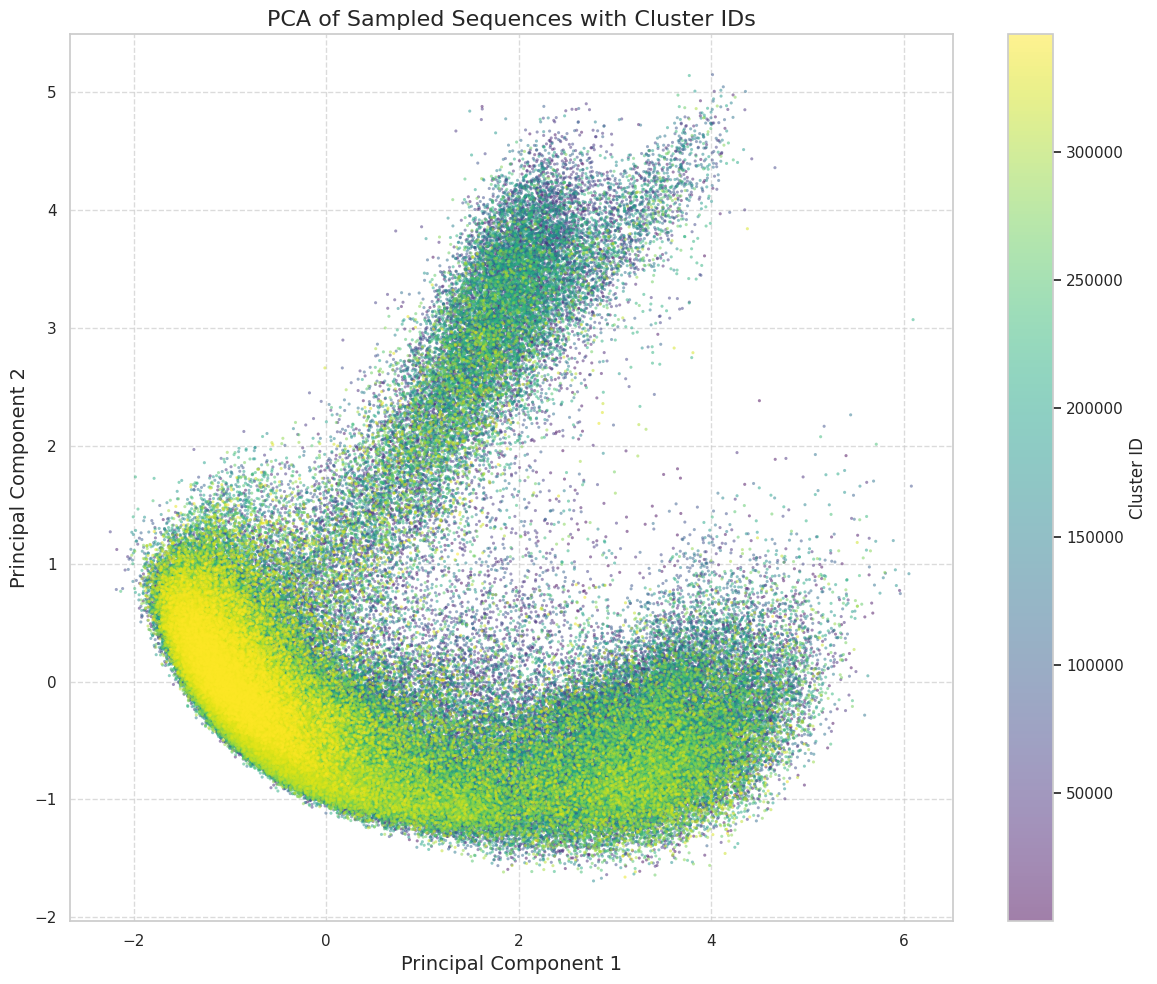

In [55]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(sampled_embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=sampled_df['cluster_id'],
    cmap='viridis',
    s=5,
    alpha=0.5,
    edgecolor='none'
)

plt.title("PCA of Sampled Sequences with Cluster IDs", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()